In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.feature_extraction.text import TfidfVectorizer

### 2.3. Q1: How do listing information differ among different neiborhoods?

In [2]:
# Listings
listing = pd.read_csv("listings.csv.gz")

In [3]:
# Dataframe from Section 2.2.
listing23 = pd.read_csv("temp/listing22.csv")
listing23.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,...,amenity_Private bathroom,amenity_Terrace,amenity_Shared hot tub,amenity_Free street parking,amenity_Fixed grab bars for shower,amenity_Pack ’n Play/travel crib,amenity_Wheelchair accessible,amenity_Outlet covers,amenity_Smoking allowed,amenity_Firm mattress
0,2384,2613,2008-08-29,NaN,NaN,1,1,1,1,Hyde Park,...,0,0,0,1,0,0,0,0,0,0
1,4505,5775,2008-12-29,1.0,100.0,1,1,1,1,Little Village,...,0,0,0,1,0,0,0,0,0,0
2,6715,15365,2009-04-30,NaN,NaN,0,2,1,0,Lincoln Park,...,0,0,0,0,0,1,0,0,0,0
3,9811,33004,2009-08-21,1.0,100.0,0,8,1,1,Old Town,...,0,0,0,0,0,0,0,0,0,0
4,10610,2140,2008-08-16,1.0,100.0,0,5,1,1,Hyde Park,...,0,0,0,1,0,0,0,0,0,0


In [4]:
# Price per person
listing23['price_per_person'] = listing23['price'] / listing23['accommodates']

#### Price by neighborhood

In [5]:
# Confirm the meaning of 'price' column
tst = listing23[['price', 'weekly_price', 'monthly_price']].dropna(subset=['weekly_price', 'monthly_price'])
tst['week_ratio'] = tst['weekly_price'] / tst['price']
tst['month_ratio'] = tst['monthly_price'] / tst['price']
week_ratio = round(tst['week_ratio'].mean(), 1)
month_ratio = round(tst['month_ratio'].mean(), 1)
print(f"Weekly price is on average {week_ratio} times of 'price', \
and monthly price is on average {month_ratio} times of 'price'. \
Therefore, 'price' column should refer to daily price of a listing.")

Weekly price is on average 6.8 times of 'price', and monthly price is on average 22.1 times of 'price'. Therefore, 'price' column should refer to daily price of a listing.


Interestingly, there are many listings with > $200 price per person per night. The extremely high price listings requires closer examination.

In [6]:
# High price listings
high_price_listings = listing.copy()
high_price_listings['price_per_person'] = listing23['price_per_person']
high_price_listings = high_price_listings.loc[high_price_listings['price_per_person']>200
                       ].sort_values(by=['price_per_person'], ascending=False)[[
    'neighbourhood', 'price_per_person', 'price', 'weekly_price', 'monthly_price', 'number_of_reviews', 'description',
    'minimum_nights', 'notes', 'property_type', 'room_type', 'accommodates', 'bathrooms',
    'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
    'first_review', 'review_scores_rating'
]]

high_price_no_review = high_price_listings.loc[high_price_listings['number_of_reviews']==0].shape[0]
high_price = high_price_listings.shape[0]
print(f"There are {high_price} listings that have price per person > $200, \
of which {high_price_no_review} have no reviews to date.")

There are 54 listings that have price per person > $200, of which 21 have no reviews to date.


These high price listings with no reviews could be outliers that are not useful in training a model that predicts price. So I will drop these rows before the machine learning step.

In [7]:
# High price listings with at least 1 review
high_price_listings.loc[high_price_listings['number_of_reviews']>0].head()

,neighbourhood,price_per_person,price,weekly_price,monthly_price,number_of_reviews,description,minimum_nights,notes,property_type,...,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,first_review,review_scores_rating
3512,Lakeview,9999.0,"$9,999.00",NaN,NaN,2,Large room with private bathroom in a 2 bedroo...,80,NaN,Apartment,...,1,1.0,0,1.0,$0.00,$30.00,1,$0.00,2017-07-31,90.0
300,Andersonville,2068.5,"$4,137.00",$375.00,"$1,500.00",214,Located in the Andersonville area with lots of...,2,INQUIRING GUESTS PLEASE NOTE: I would be happy...,House,...,2,1.0,1,1.0,NaN,NaN,2,$0.00,2014-05-21,96.0
443,Lakeview,500.0,"$1,000.00",$533.00,"$1,953.00",19,This is a perfect place to stay for a short ti...,2,NaN,Apartment,...,2,1.0,1,1.0,$200.00,$100.00,1,$0.00,2015-06-15,91.0
3549,Little Village,500.0,"$1,000.00",NaN,NaN,25,"This is a clean, comfy & kind safe accommodati...",4,-Standard Check-In 4 pm to 10 pm. -Standard C...,Apartment,...,2,1.0,1,1.0,$200.00,$18.00,1,$7.00,2017-11-12,95.0
3132,Portage Park,500.0,"$1,000.00",NaN,NaN,1,NaN,1,NaN,Apartment,...,2,1.0,1,1.0,NaN,NaN,1,$0.00,2018-09-29,NaN


It seems that some of the listings (e.g. listing in the 2nd and 3rd row above) put wrong information into the `price` column, which will bias the predictive model. Therefore, I will drop the high price per person listings unless the `price` < `weekly_price` or `price` < 1/4`monthly_price`.

In [8]:
# Drop >$1000 price unless price is reasonable compared to weekly or monthly price
listing23 = listing23.loc[((listing23['price_per_person']>=200) & 
                           (listing23['weekly_price'].notna()) & 
                           (listing23['weekly_price'] > listing23['price'])) |
                          ((listing23['price_per_person']>=200) & 
                           (listing23['monthly_price'].notna()) & 
                           (listing23['monthly_price'] > 4*listing23['price'])) |
                          (listing23['price_per_person']<200)
                         ]

# ANOVA price per person
model1 = smf.ols(formula='price_per_person ~ C(neighbourhood)', data=listing23).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:       price_per_person   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     21.21
Date:                Tue, 20 Nov 2018   Prob (F-statistic):          1.83e-284
Time:                        20:53:00   Log-Likelihood:                -32403.
No. Observations:                7263   AIC:                         6.498e+04
Df Residuals:                    7176   BIC:                         6.558e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

After excluding these high per person price listings, the relationsihp between neighbourhood and per person price is statistically significantly. An analysis of variance (ANOVA) revealed that listings in different neighbourhoods have significantly different price per perspn, with F=21.21, p<0.0001, meaning that different neighbourhood and per person price are significantly associated.

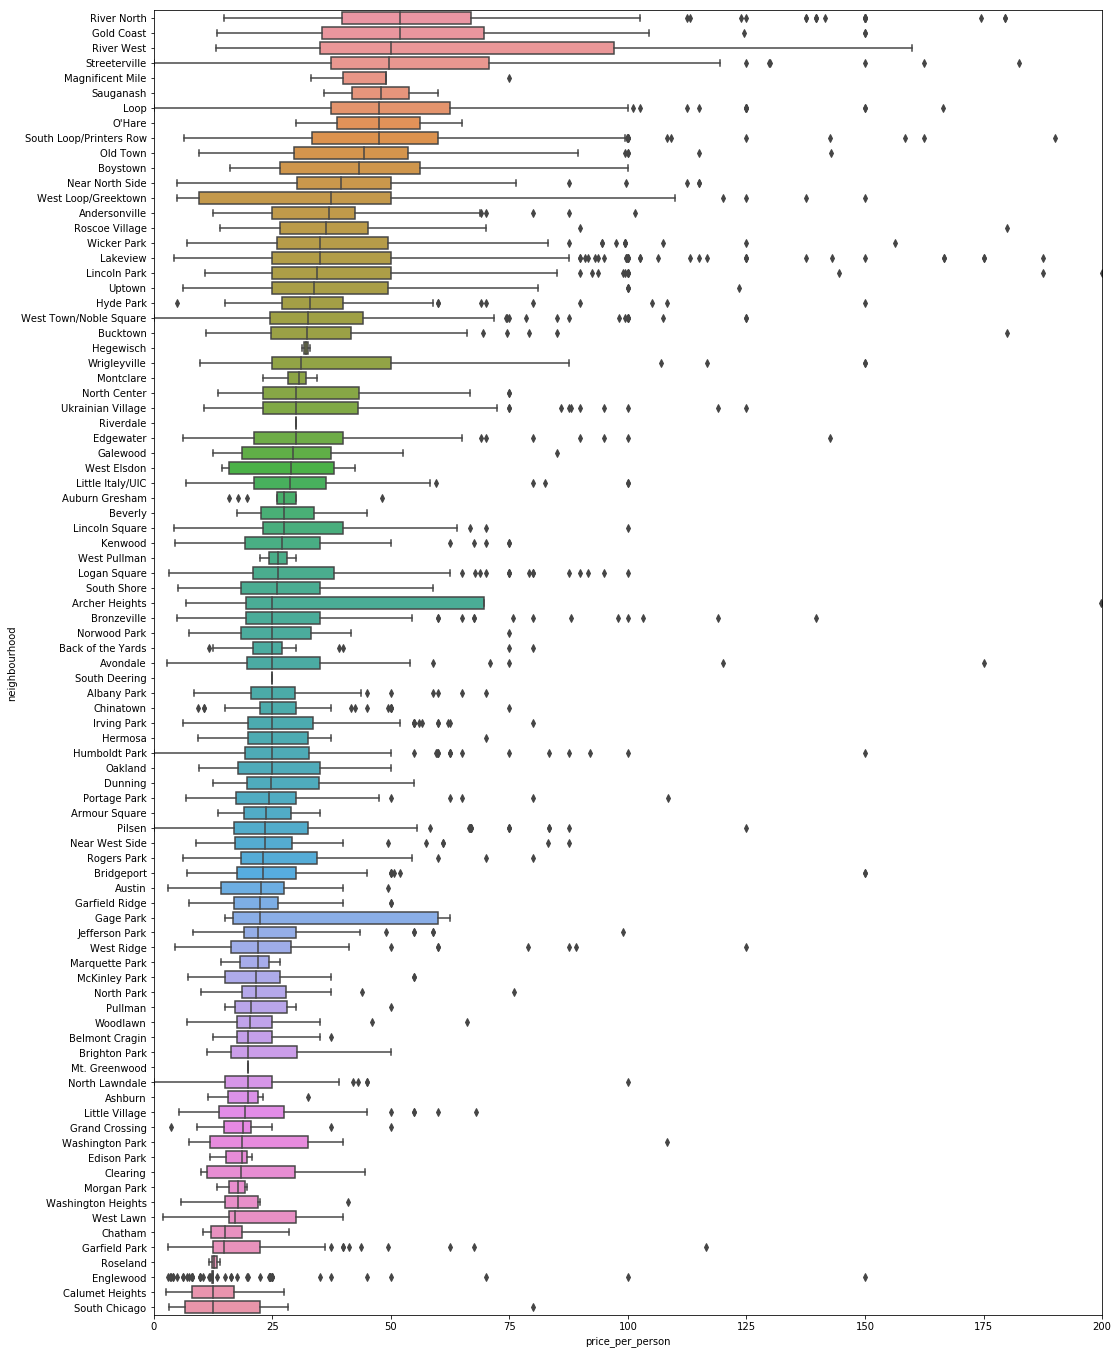

In [9]:
# Median price by neighborhood
med_price_by_nb = listing23[['neighbourhood', 'price_per_person']
         ].groupby(by=['neighbourhood']).median().sort_values(by=['price_per_person'], ascending=False)

# Boxplot of listing price by neighborhood
fig = plt.figure(figsize = (17, 24))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x="price_per_person", y="neighbourhood", data=listing23, orient='h', ax=ax, order=med_price_by_nb.index)
plt.xlim([0, 200]);
# plt.savefig("figures/pricepp_by_neighborhood.png");

#### Descriptions by neighborhood

In [10]:
# Combine descriptive sentences for each listing
description = listing[['id', 'name', 'space', 'description', 'neighborhood_overview', 'neighbourhood']]
description = description.dropna(subset=['neighbourhood']).fillna('')
description['descriptive_words'] = description.apply(lambda x: f"{x['name']} {x['space']} \
{x['description']} {x['neighborhood_overview']} ", axis=1)
description = description[['descriptive_words', 'neighbourhood']]

# Combine descriptive sentences for each neighborhood
description_nb = description.groupby(by=['neighbourhood'])['descriptive_words'].sum()

In [11]:
# Tf-idf of descriptive words for each neighborhood
corpus = description_nb
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(corpus)

In [12]:
# Top word(s) based on tf-idf of each neighborhood
n = 4
feature_array = np.array(vectorizer.get_feature_names())

print(f"Top {n} phrases that characterize each neighborhood:\n")
for i, nb in enumerate(description_nb.index):
    response = X[i]
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:n]
    print(f"{nb}: {', '.join(top_n)}")

Top 4 phrases that characterize each neighborhood:

Albany Park: albany park, chicago, albany, brown line
Andersonville: andersonville, room, neighborhood, restaurants
Archer Heights: midway, midway international, close, close midway
Armour Square: chinatown, mccormick, downtown, sox
Ashburn: basement, home, chicago, safe police
Auburn Gresham: major expressways, travelers self, water pets, expressways home
Austin: oak park, chicago, oak, park
Avondale: logan, logan square, avondale, square
Back of the Yards: stone mosaic, remodeled bedrooms, furniture mattresses, mosaic hardwood
Belmont Cragin: room, bedroom, mini kitchen, kitchen
Beverly: beverly, room, chicago, city
Boystown: boystown, lakeview, halsted, wrigley
Bridgeport: bridgeport, chicago, room, bed
Brighton Park: place, midway, apartment, minutes
Bronzeville: bronzeville, chicago, mccormick, mccormick place
Bucktown: bucktown, wicker, wicker park, park
Calumet Heights: cozinha, salas, mansion shared, quarto
Chatham: chatham, c

### 2.4. Q2: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Chicago?

#### Housing demand 

In [13]:
# Reviews summary
review_summary = pd.read_csv("reviews.csv")
print("Review summay table:")
print(f"rows, cols: {review_summary.shape}")
review_summary.head()

Review summay table:
rows, cols: (259883, 2)


,listing_id,date
0,2384,2015-01-09
1,2384,2015-03-24
2,2384,2015-04-19
3,2384,2015-04-30
4,2384,2015-05-04


In [14]:
# Convert review date to datetime
review_summary['date'] = pd.to_datetime(review_summary['date'], format='%Y-%m-%d')

In [15]:
# Use the number of reviews as a proxy for the housing demand
review_count = review_summary.groupby(by=['date']).count().rename(columns={'listing_id': 'visitors_count'})
review_count.to_csv("temp/review_count.csv", index=False)
review_count_monthly = review_count.resample('M').sum()
# review_count_monthly.head()

#### Housing supply

In [16]:
# Use host_since and the corresponding listings as a proxy for the number of new listing at a given time
listing23['host_since'] = pd.to_datetime(listing23['host_since'], format='%Y-%m-%d')
new_listing_count = listing23.groupby(by=['host_since'])[['id']].count().rename(columns={'id': 'new_listings_count'})
new_listing_count.to_csv("temp/new_listing_count.csv", index=False)
new_listing_count_monthly = new_listing_count.resample('M').sum()
# new_listing_count_monthly.head()

# The cumulated sum of the number of new listings over time is hence a proxy for the housing supply
listing_count_monthly = new_listing_count_monthly.cumsum().rename(columns={'new_listings_count': 'listings_count'})
# listing_count_monthly.head()

In [17]:
# Merge demand and supply into one dataframe
demand_supply = review_count_monthly.merge(listing_count_monthly, how="outer", left_index=True, right_index=True)
# demand_supply.head()

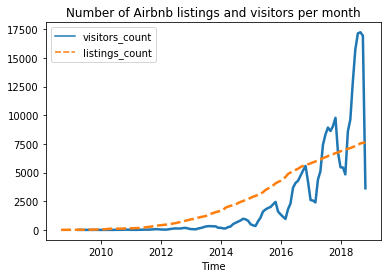

In [18]:
# Trend of monthly supply and demand over time
sns.lineplot(data=demand_supply, palette="tab10", linewidth=2.5)
plt.xlabel('Time')
plt.title('Number of Airbnb listings and visitors per month')
plt.savefig('figures/demand_supply.png')

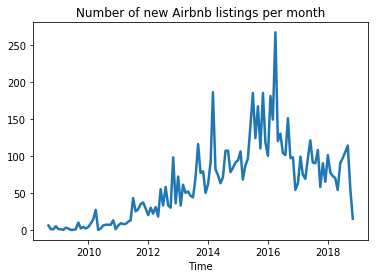

In [19]:
# Trend of new listings over time
sns.lineplot(data=new_listing_count_monthly, palette="tab10", linewidth=2.5)
plt.xlabel('Time')
plt.title('Number of new Airbnb listings per month')
plt.legend().set_visible(False)
plt.savefig('figures/new_listings_over_time.png')

### 2.5. Q3: What are the busiest times of a year to visit Chicago? By how much do prices spike?

In [20]:
# Calendar
calendar = pd.read_csv("data/calendar.csv.gz")
print("Calendar table:")
print(f"rows, cols: {calendar.shape}")
# calendar.head()

Calendar table:
rows, cols: (2798090, 4)


In [21]:
# Convert data types
calendar['date'] = pd.to_datetime(calendar['date'], format='%Y-%m-%d')
calendar['price'] = calendar['price'].str.strip('$').str.replace(',', '').astype('float')

# Calculate average listing price by date
calendar.index = calendar['date']
daily_price = calendar[['price']].resample('D').mean()
# daily_price.head()

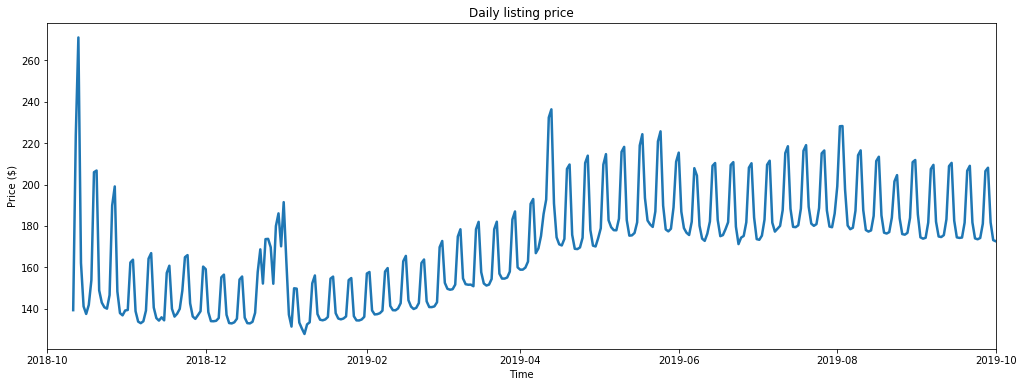

In [22]:
# Trend of mean daily listing price over time
fig = plt.figure(figsize = (17, 6))
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(data=daily_price, palette="tab10", linewidth=2.5, ax=ax)
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.title('Daily listing price')
plt.legend().set_visible(False)
plt.xlim(datetime.datetime(2018, 10, 1), datetime.datetime(2019, 10, 1))
plt.savefig('figures/price_over_time.png')

In [23]:
# Use daily number of reviews as a proxy of daily demand
daily_demand = review_count.loc[(review_count.index > datetime.datetime(2017, 10, 1))]
# daily_demand.head()

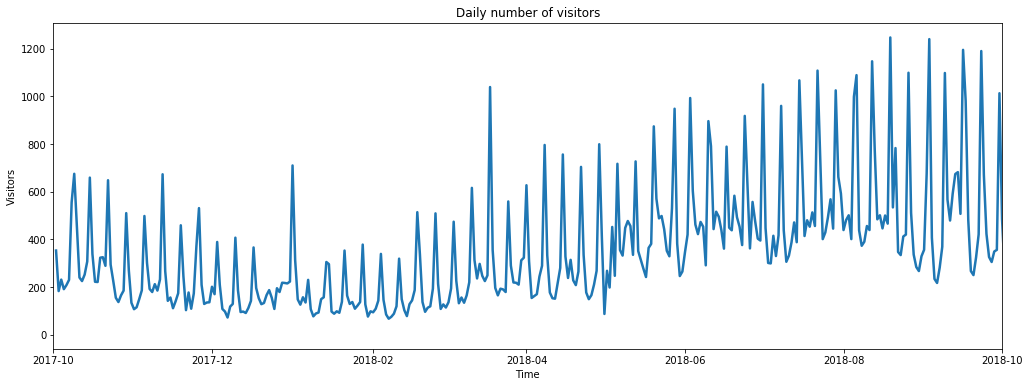

In [24]:
# Trend of daily visitors over time
fig = plt.figure(figsize = (17, 6))
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(data=daily_demand, palette="tab10", linewidth=2.5, ax=ax)
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.title('Daily number of visitors')
plt.legend().set_visible(False)
plt.xlim(datetime.datetime(2017, 10, 1), datetime.datetime(2018, 10, 1))
plt.savefig('figures/demand_over_time.png')

In [25]:
print("Number of visitors in each month:")
visitor_by_month = daily_demand.resample('M').sum()
visitor_by_month

Number of visitors in each month:


,visitors_count
date,
2017-10-31,9208
2017-11-30,6796
2017-12-31,5462
2018-01-31,5435
2018-02-28,4840
2018-03-31,8582
2018-04-30,9618
2018-05-31,12954
2018-06-30,15732


The busiest time of a year to visit Chicago is August.

In [26]:
print("Mean daily price for each month:")
price_by_month = daily_price.resample('M').mean()
price_by_month

Mean daily price for each month:


,price
date,
2018-10-31,164.450222
2018-11-30,145.235274
2018-12-31,150.867792
2019-01-31,140.289624
2019-02-28,146.350093
2019-03-31,161.478283
2019-04-30,182.688514
2019-05-31,191.675472
2019-06-30,187.699754


In general, January has the lowest price (\$145), and August has the highest price (\$192).

#### Save checkpoint

In [28]:
listing23.to_csv("temp/listing23.csv", index=False)

To be continued in `model.ipynb`